## Device configuration

In [8]:
from tinygrad import Device

print(Device.DEFAULT)

METAL


## Model

In [9]:
from tinygrad import Tensor, nn

class Model:
  def __init__(self):
    self.l1 = nn.Conv2d(1, 32, kernel_size=(3,3))
    self.l2 = nn.Conv2d(32, 64, kernel_size=(3,3))
    self.l3 = nn.Linear(1600, 10)

  def __call__(self, x:Tensor) -> Tensor:
    x = self.l1(x).relu().max_pool2d((2,2))
    x = self.l2(x).relu().max_pool2d((2,2))
    return self.l3(x.flatten(1).dropout(0.5))

## Get the MNIST dataset

In [10]:
from tinygrad.nn.datasets import mnist

X_train, Y_train, X_test, Y_test = mnist()
# Use only half of the training dataset
X_train = X_train[:len(X_train)//2]
Y_train = Y_train[:len(Y_train)//2]
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

(30000, 1, 28, 28) dtypes.uchar (30000,) dtypes.uchar


## Use the model

In [11]:
model = Model()
acc = (model(X_test).argmax(axis=1) == Y_test).mean()
print(acc.item())  

0.11789999902248383


### Train the model

In [12]:
optim = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 128
def step():
    Tensor.training = True  # makes dropout work
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X, Y = X_train[samples], Y_train[samples]
    optim.zero_grad()
    loss = model(X).sparse_categorical_crossentropy(Y).backward()
    optim.step()
    return loss

In [13]:
from tinygrad import TinyJit

jit_step = TinyJit(step)

In [14]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for step in range(7000):
    # Calculate train loss
    loss = jit_step()
    train_losses.append(loss.item())

    if step%100 == 0:
        Tensor.training = False     # Disables dropout for evaluation

        # Calculate train accuracy
        train_outputs = model(X_train)
        train_acc = (train_outputs.argmax(axis=1) == Y_train).mean().item()
        train_accuracies.append(train_acc)

        # Calculate test accuracy
        test_outputs = model(X_test)
        test_acc = (test_outputs.argmax(axis=1) == Y_test).mean().item()
        test_accuracies.append(test_acc)

        # Calculate test loss
        test_loss = test_outputs.sparse_categorical_crossentropy(Y_test).mean().item()
        test_losses.append(test_loss)

        print(f"step {step:4d}, loss {loss.item():.2f}, train acc {train_acc*100.:.2f}%, test acc {test_acc*100.:.2f}%")
        #print(f"step {step:4d}, loss {loss.item():.2f}, test acc {test_acc*100.:.2f}%")

step    0, loss 25.80, train acc 16.51%, test acc 17.16%
step  100, loss 0.21, train acc 94.54%, test acc 94.80%
step  200, loss 0.19, train acc 96.57%, test acc 96.41%
step  300, loss 0.14, train acc 97.00%, test acc 96.90%
step  400, loss 0.08, train acc 97.46%, test acc 97.18%
step  500, loss 0.14, train acc 97.88%, test acc 97.52%
step  600, loss 0.11, train acc 98.12%, test acc 97.49%
step  700, loss 0.17, train acc 98.26%, test acc 97.88%
step  800, loss 0.05, train acc 98.44%, test acc 97.85%
step  900, loss 0.20, train acc 98.15%, test acc 97.70%
step 1000, loss 0.18, train acc 98.57%, test acc 97.85%
step 1100, loss 0.10, train acc 98.61%, test acc 97.83%
step 1200, loss 0.09, train acc 98.69%, test acc 98.06%
step 1300, loss 0.17, train acc 98.70%, test acc 98.14%
step 1400, loss 0.21, train acc 98.97%, test acc 98.34%
step 1500, loss 0.12, train acc 99.09%, test acc 98.44%
step 1600, loss 0.07, train acc 98.92%, test acc 98.17%
step 1700, loss 0.15, train acc 98.87%, test ac

### Plot the loss

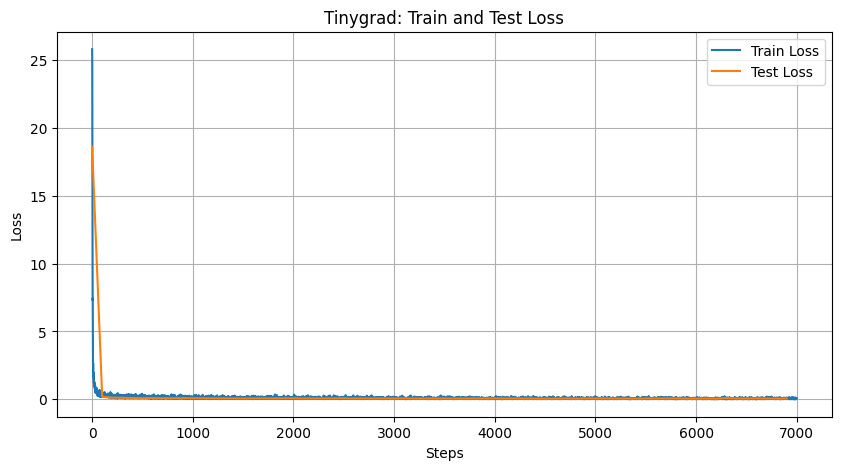

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(test_losses) * 100, 100), test_losses, label='Test Loss') # every 100 steps
plt.title('Tinygrad: Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot the accuracy

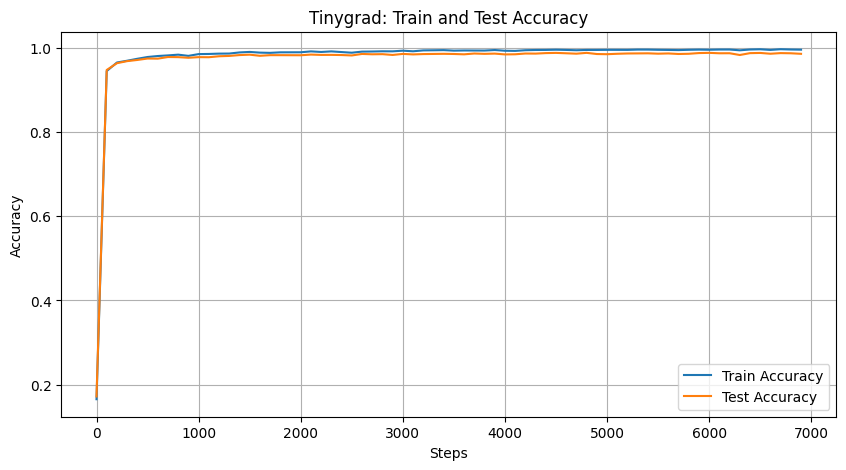

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_accuracies) * 100, 100), train_accuracies, label='Train Accuracy')
plt.plot(range(0, len(test_accuracies) * 100, 100), test_accuracies, label='Test Accuracy')
plt.title('Tinygrad: Train and Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Save the weights

In [17]:
import numpy as np

tinygrad_weights = {
    'l1.weight': model.l1.weight.numpy(),
    'l1.bias': model.l1.bias.numpy(),
    'l2.weight': model.l2.weight.numpy(),
    'l2.bias': model.l2.bias.numpy(),
    'l3.weight': model.l3.weight.numpy(),
    'l3.bias': model.l3.bias.numpy()
}
np.save('tinygrad_weights.npy', tinygrad_weights)

## Final probabilities

In [18]:
test_image = X_test[0:1]
tinygrad_probs = model(test_image).softmax().numpy()
print("tinygrad probabilities:", tinygrad_probs)

tinygrad probabilities: [[2.6096082e-13 1.2902166e-15 3.1515489e-07 2.1935047e-09 4.6694294e-19
  1.0634592e-16 2.9911202e-26 9.9999964e-01 2.9652418e-12 2.1830120e-12]]
